**Using Mortgage Compliance Data to Detect Redlining**
<br>
<br>
***Project Purpose***
<br>
The purpose of this project is to determine if data can be used by a lending institution to identify if redlining is taking place. The code for this project will involve the transformation of the original dataset, model creation and training, and the interpretation of the model's results.
<br>
***About the Data***
<br>
The data being used for this project was supplied by a relative who works at a lending instution and is in charge of sending their HMDA (Housing Mortgage Disclosure Act) to the CFPB (Consumer Financial Protection Bureau) to comply with federal regulations. The data was scrubbed of personally identifying information before being sent to me for use.
<br>
The dataset contains 1,888 rows and 204 columns. Each row is a seperate application for a mortgage from the same lending institution. The applications were submitted in the 180 days leading up to June 3rd, 2024. Each column represents a field of data regarding race, ethnicity, financial information, loan information (including the decision made for the application), or location information for the property in question. Race and ethnic information are required to be reported by federal law in order to police redlining, which was made illegal with the Fair Housing Act of 1968.
<br>
In the dataset, 1,372 applications ended up having loans originated. 42 applications were approved by the lender but were not accepted by the applicants. 388 applications were withdrawn by the applicant before the lender made a decision. 85 applications were denied by the lender. 1 application was closed by the lender due to it being incomplete.
<br>
The nature of this dataset is lopsided with few applications actually being denied and the majority being approved and/or having loans originated. This will have to be taken into account during model creation by weighting the classes. Since the lender is being judged on whether or not redlining is taking place, the results of "Loan Originated" and "Application approved but not accepted" will be combined into the same result. The lender was willing to lend to those who chose not to accept the loan.
<br>
***Cleaning the Data***
<br>
The data in the spreadsheet has placeholder values in some fields where information was not supplied. Some fields contain numerical information that ended up being interpreted as strings. Fields for race and ethnic information have a lot of blank/NA values that need to be filled as well.

In [2]:
# Initial import of libraries
import pandas as pd
import numpy as np

In [3]:
# Importing the data
raw = pd.read_excel('sample data last 180 days.xlsx', header=0)

In [4]:
# Filtering the raw data for those where the application was either approved or denied
acted = raw[(raw.ACTION != 'Application withdrawn') & (raw.ACTION != 'File Closed for incompleteness')].reset_index(drop=True)

In [5]:
# Function to convert numerical values stored as strings while taking placeholder values into account, leaving those and blanks as NaN
def strtoint(i):
    try:
        if i != '8888':  # Placeholder value for no credit score
            num = int(i)
        else:
            num = np.NaN  # Replaces with NaN if present
    except:  # Exception since a value could end up beeing blank
        num = np.NaN
    return num


def floattoint(i):
    try:
        if i != '8888':  # Placeholder value for no credit score
            num = float(i)
        else:
            num = np.NaN  # Replaces with NaN if present
    except:  # Exception since a value could end up beeing blank
        num = np.NaN
    return num

In [6]:
# Filling empty spaces with NA values and replacing other placeholder values
acted_filled = acted.replace({'8888' : np.nan, '9999' : np.nan, ' ' : np.nan})

C:\Users\dman1\AppData\Local\Temp\ipykernel_30408\1441454125.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  acted_filled = acted.replace({'8888' : np.nan, '9999' : np.nan, ' ' : np.nan})


***Simplifying the Race and Ethnic Fields***
<br>
With values filled using numbers instead of letters or NA values, we need to identify the fields for race and ethnic information. There are 58 fields regarding race and 28 regarding ethnicity. These can be simplified in order to make our model's task easier. Helper functions can be defined to identify the columns with the corresponding race or ethnicity information. Once that information has been attained, we can simplify the combined 86 fields down to 6. The goal will to be to create a simpler dataframe to be used to join with economic and loan information to be used as the modeling dataset.

In [8]:
# Helper functions to use to simplify race and ethnic information

# Getting column names
def get_cols(df, string):
    col_list = []
    for column in df.columns:
        if string in column:
            col_list.append(column)
        else:
            continue
    return col_list


# Function to aid in boolean indexing
def bool_filter(df):
    bool_list = []
    i = 0
    while i < len(df):
        bool = df.iloc[i].sum() > 0
        bool_list.append(bool)
        i += 1
    return bool_list

In [9]:
# Identifying columns with race, ethnic, or sex information
eth_cols = []
race_cols = []
gend_cols = []
for column in acted_filled.columns:
    if 'ETH' in column:
        eth_cols.append(column)
    elif 'RACE' in column:
        race_cols.append(column)
    elif 'SEX' in column:
        gend_cols.append(column)    
    else:
        continue

# Filling the race and ethnic NAs
for column in (eth_cols + race_cols + gend_cols):    
    acted_filled[column] = acted_filled[column].replace({'Y' : 1, 'N' : 0})
    acted_filled[column] = acted_filled[column].fillna(0)

# Subsetting hmda_raw for the race and ethnic fields
eth = acted_filled[eth_cols]
race = acted_filled[race_cols]
gend = acted_filled[gend_cols]

C:\Users\dman1\AppData\Local\Temp\ipykernel_30408\438901637.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  acted_filled[column] = acted_filled[column].replace({'Y' : 1, 'N' : 0})


In [10]:
# Applying helper functions to ethnic data for Hispanic and Latino/a applicants\
# (All ethnic information dealt with Hispanic and Latino/a identification)

# Getting the Hispanic/Latino response fields
hisplat_cols = get_cols(eth, 'HMDA_1')

# Creating a dataframe of just the Hispanic/Latino fields
hisplat = eth[hisplat_cols]

# Creating a field to allow ease of indexing for Hispanic/Latino applicants an co-applicants using a while loop
hisplat_bool = bool_filter(hisplat)

In [11]:
# Applying helper functions to racial data to simplify data into racial groups

# Getting column lists for each racial group
nat_cols = get_cols(race, 'RACE-1')  # Natve America Columns
as_cols = get_cols(race, 'RACE-2') + get_cols(race, 'HMDA_2') # Asian Columns Part 1
b_cols = get_cols(race, 'RACE-3')  # Black Columns
pac_cols = get_cols(race, 'RACE-4') + get_cols(race, 'HMDA_4') # Pacific Columns Part 1
w_cols = get_cols(race, 'RACE-5')  # White Columns

# Subsetting the race dataframe by race columns
native = race[nat_cols]
asian = race[as_cols]
black = race[b_cols]
pacific = race[pac_cols]
white = race[w_cols]

# Creating the boolean filter lists for each racial group
native_bool = bool_filter(native)
asian_bool = bool_filter(asian)
black_bool = bool_filter(black)
pacific_bool = bool_filter(pacific)
white_bool = bool_filter(white)

In [12]:
# Getting column lists for each racial group
male_cols = get_cols(gend, 'HMDA_1')  # Male Columns
female_cols = get_cols(gend, 'HMDA_2')  # Female Columns

# Subsetting the race dataframe by race columns
male = gend[male_cols]
female = gend[female_cols]

# Creating the boolean filter lists for each racial group
male_bool = bool_filter(male)
female_bool = bool_filter(female)

In [13]:
# Creating new dataframe to hold features from extraction
dataL = pd.DataFrame({
                    'HISPLAT' : hisplat_bool,
                    'NATIVE' : native_bool,
                    'ASIAN' : asian_bool,
                    'BLACK' : black_bool,
                    'PACIFIC' : pacific_bool,
                    'WHITE' : white_bool,
                    'MALE' : male_bool,
                    'FEMALE' : female_bool})

# Creating the simplified dataframe containing race and ethnic information
dataL = dataL.replace({True : 1, False : 0})

C:\Users\dman1\AppData\Local\Temp\ipykernel_30408\2165902182.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataL = dataL.replace({True : 1, False : 0})


***Simplifying the Non-Race, Non-Ethnic, and Non-Sex Data***
<br>
The data to be simplified here pertains to economic and loan information. To work with only this data, the race and ethnic information need to be dropped. Afterwards, columns that make sense for inclusion can be singled out for inclusion.

In [15]:
# Dropping the fields of race data held in eth_cols and race_cols
non_eth = acted_filled.drop(columns=eth_cols)
non_ethrac = non_eth.drop(columns=race_cols)  
non_gendethrac = non_ethrac.drop(columns=gend_cols)  # Data without race, ethnic, or sex information

Common economic indicators for mortgage applicants include income, credit score, combined loan to value ratio (CLTV), debt to income ratio (DTI). Pertinent information for the location of the property to be placed under the mortgage will include its location (we will use zip code) and its appraised value. Important loan information will include the type of loan and the total principle to be loaned. 

In [17]:
# Beginning the economic and loan dataframe
dataR = acted_filled[['LNTYPE_HMDA', 'LNAMOUNTFL', 'PROPZIP_HMDA', 'CLTV_HMDA', 'APPRVALUE_HMDA', 'DEBT_RATIO', 
                            'TINCOME_HMDA', 'APCRSCORE']]
# Converting string columns of numeric information to integers
dataR.CLTV_HMDA = dataR.CLTV_HMDA.map(lambda x: floattoint(x))
dataR.APCRSCORE = dataR.APCRSCORE.map(lambda x: strtoint(x))

C:\Users\dman1\AppData\Local\Temp\ipykernel_30408\3605478135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataR.CLTV_HMDA = dataR.CLTV_HMDA.map(lambda x: floattoint(x))
C:\Users\dman1\AppData\Local\Temp\ipykernel_30408\3605478135.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataR.APCRSCORE = dataR.APCRSCORE.map(lambda x: strtoint(x))


In [18]:
# Creating the dataframe to use for modeling
data = dataL.merge(dataR, how='outer', on=dataL.index)
data = data.drop(columns=['key_0'])
data = data.merge(acted_filled.ACTION, on=data.index)
data = data.drop(columns=['key_0'])
data.ACTION = data.ACTION.replace({'Application denied' : 0,
                                   'Loan Originated' : 1,
                                   'Application approved but not accepted' : 1})

C:\Users\dman1\AppData\Local\Temp\ipykernel_30408\357208571.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.ACTION = data.ACTION.replace({'Application denied' : 0,


***Preparing the Modeling Dataset for Modeling***
<br>
With the modeling dataset now merged, we will want to make sure it is ready for modeling. This will include dummying categorical variables and standardization of the data. Standardizing the data will be done using a Min/Max scaler from scikit-learn. This will preserve the Boolean values in the data while scaling the numeric values in terms of percentages within the field.

In [20]:
# Dummying the modleing data
data_dumm = pd.get_dummies(data, dtype=int)

After scaling and imputing the data, the resulting dataset for modeling has 85 applications that were denied and 1414 applications that were approved by the lending institution. 
<br>
***Modeling the Data***
<br>
With the data now dummied and scaled, we can begin the modeling process. For the data, we will want to spit it into feature and target sets. These will then be used to split into training and testing sets for the models to use.
<br>
Since this is a classification task, we will want to use models like logistic regression or random forest classification. To find the best model, we can grid search using both models and windows of parameters. This will require a pipeline and a search space that specifies the particular classiefier, penalty parameters, and parameters specific to the model. Once that has been established, we will want to make sure that the classes are balanced by the model since there is a massive difference between the number of approved and denied applications.

In [22]:
# Importing for modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [23]:
# Creating the features and target sets
modeling_features = data_dumm.drop(columns=['ACTION'])
modeling_target = data_dumm.ACTION

In [24]:
# Creating the training and testing sets
feat_train, feat_test, targ_train, targ_test = train_test_split(modeling_features, modeling_target,
                                                               test_size=0.2, random_state=40509)

In [25]:
# Creating the Pipeline for the Grid Search
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('imputer', SimpleImputer(strategy='median')),
                     ('classifier' , LogisticRegression())])

In [26]:
# Creating the search space to use for the Grid Search
search_space = [{'classifier' : [LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')],
                'classifier__penalty' : ['l1', 'l2'],
                'classifier__C' : np.logspace(0, 4, 15)},
                {'classifier' : [RandomForestClassifier(n_jobs=-1, class_weight='balanced')],
                'classifier__n_estimators' : [10, 100, 1000],
                'classifier__max_features' : [1, 2, 3],
                'classifier__min_samples_leaf' : [10, 15, 20]}]

In [27]:
# Creating th GridSearchCV object
gridsearch = GridSearchCV(pipeline, search_space, cv=5, verbose=0)

# Fitting the gridsearch model
model_search = gridsearch.fit(feat_train, targ_train)

# Finding and printing the best model's parameters
print(model_search.best_estimator_)
model = model_search.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('classifier',
                 LogisticRegression(C=7.196856730011519,
                                    class_weight='balanced', max_iter=500,
                                    penalty='l1', solver='liblinear'))])


***Evaluating the Selected Model***
<br>
Now with the model selected, we can make predictions and evaluate them using classification metrics like accuracy, precision, recall, the F1 score, ROC curve, and the area under the ROC curve (AUC).

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Making model predicitons
preds = model.predict(feat_test)

# Getting model accuracy score
accuracy = accuracy_score(targ_test, preds)
print("The model's accuracy is", accuracy)

# Getting model precision score
precision = precision_score(targ_test, preds)
print("The model's precision is", precision)

# Getting model recall score
recall = recall_score(targ_test, preds)
print("The model's recall is", recall)

# Getting model F1-Score
f1 = f1_score(targ_test, preds)
print("The model's f1 score is", f1)

The model's accuracy is 0.98
The model's precision is 0.9929078014184397
The model's recall is 0.9859154929577465
The model's f1 score is 0.9893992932862191


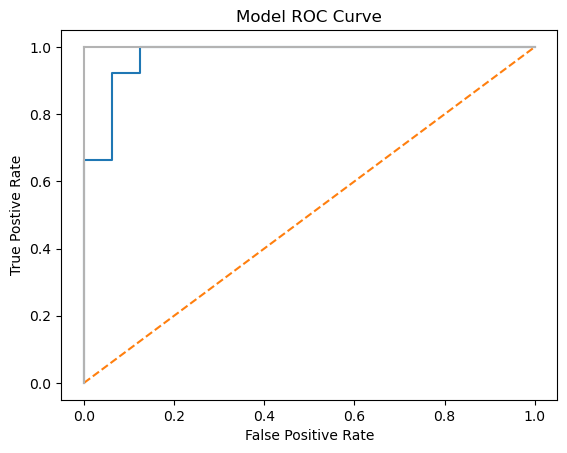

AUC score =  0.974031690140845


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Making the ROC Curve
target_probabilities = model.predict_proba(feat_test)[:,1]
fp_rate, tp_rate, threshold = roc_curve(
    targ_test, target_probabilities)

# Plotting the ROC Curve
plt.title('Model ROC Curve')
plt.plot(fp_rate, tp_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0], [1,0], c='.7'), plt.plot([1,1], c='.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.show()
print('AUC score = ', roc_auc_score(targ_test, target_probabilities))

A confusion matrix can also breakdown how the model performed.

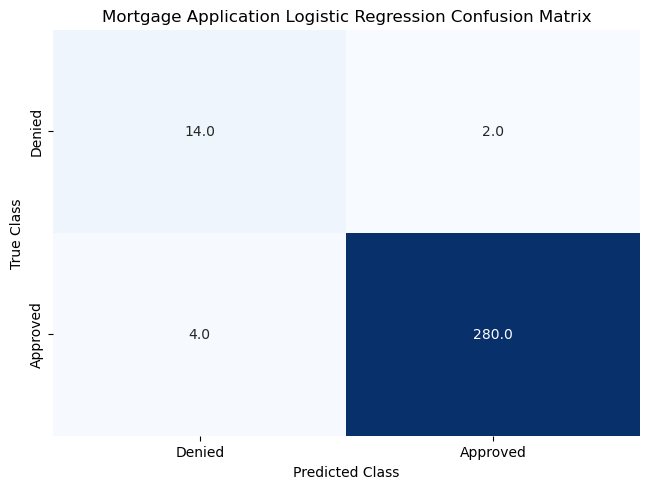

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Making the confusion matrix
conf_matrix = confusion_matrix(targ_test, preds)
class_names = ['Denied', 'Approved']
conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Visualizing the confusion matrix as a heatmap
sns.heatmap(conf_df, annot=True, cbar=None, cmap='Blues', fmt='.1f')
plt.title('Mortgage Application Logistic Regression Confusion Matrix'), plt.tight_layout()
plt.ylabel('True Class'), plt.xlabel('Predicted Class')
plt.show()

We can see from the confusion matrix that the model only denied 4 applications from the test set that were actually approved and only approved 2 applications that were actually denied.
<br>
Next we can check out summary statistics for various financial metrics to compare denied applications with the approved applications

In [34]:
# Indexding the testing features for those predicted to be denied and originated
pred_denials = feat_test[preds == 0]
pred_approvals = feat_test[preds == 1]

# Finding summary statistics for income, credit score, and loan amount
pred_denials.agg({'APCRSCORE' : 'describe',
                  'LNAMOUNTFL' : 'describe',
                  'TINCOME_HMDA': 'describe'})

,APCRSCORE,LNAMOUNTFL,TINCOME_HMDA
count,18.000000,18.000000,18.000000
mean,572.333333,287166.722222,91.305333
std,72.624741,87941.694524,48.322281
min,475.000000,32000.000000,24.000000
25%,516.750000,252485.000000,68.500000
50%,567.500000,292975.000000,79.000000
75%,594.500000,338750.000000,107.000000
max,772.000000,395000.000000,209.000000


In [35]:
pred_approvals.agg({'APCRSCORE' : 'describe',
                       'LNAMOUNTFL' : 'describe',
                       'TINCOME_HMDA': 'describe'})

,APCRSCORE,LNAMOUNTFL,TINCOME_HMDA
count,282.000000,2.820000e+02,281.000000
mean,746.315603,3.731981e+05,153.928826
std,47.313481,2.103765e+05,136.776781
min,620.000000,7.500100e+04,22.000000
25%,711.000000,2.360495e+05,85.000000
50%,758.500000,3.292000e+05,120.000000
75%,785.000000,4.499000e+05,174.000000
max,820.000000,1.620000e+06,1429.000000


The summary statistic data above from approved and denied application suggests that the model performs well - applications with lower credit scores and lower incomes tend to be declined while those with higher credit scores and incomes tend to be approved.
<br>
To be thorough, we can use the median (50%) statistics from the approved predictions to filter through the all of the denied applications in the dataset to see examples of denied applications that would have originally been approved. We can then look through that data to find what could have been the basis for denial.

In [37]:
# Filtering for denied applications
denials = data[data.ACTION == 0]

# Creating filtering criteria for financial metrics
criteria = (denials['APCRSCORE'] >= 758.5) & (denials['TINCOME_HMDA'] >= 120)

# Filtering using the criteria
suspects = denials[criteria]

In [38]:
suspects

,HISPLAT,NATIVE,ASIAN,BLACK,PACIFIC,WHITE,MALE,FEMALE,LNTYPE_HMDA,LNAMOUNTFL,PROPZIP_HMDA,CLTV_HMDA,APPRVALUE_HMDA,DEBT_RATIO,TINCOME_HMDA,APCRSCORE,ACTION
1485,0,1,0,0,0,1,0,1,Conventional,212000.0,29577,73.868,287000.0,27.57,188.0,771.0,0


Using this filtering criteria, we find that there is only one denied application. We can use the information here to find the reason the application was denied through filtering the original dataset. The reason for denial is included in that data but was not used for modeling for obvious reasons.

In [40]:
raw[(raw['LNTYPE_HMDA'] == 'Conventional') &
(raw['ACTION'] == 'Application denied') &
(raw['PROPZIP_HMDA'] == '29577')].DENIALR1

1872    Collateral
Name: DENIALR1, dtype: object

We can see that the reason for this application's denial was for its collateral. The applicant did identify as Native American as well as White. In a system incorporating this process to flag denied applications for investigation by the lending institution to make sure redlining is not taking place, this application would likely be invesitgated.

In [80]:
data.to_excel('modeling data.xlsx', index=False, sheet_name='Data')

In [82]:
conf_df.to_excel('confusion matrix.xlsx', index=False, sheet_name='Confusion Matrix')